In [1]:
TEAM_NAME = "EXPERIMENTS"  # enter team name

In [2]:
import warnings
import numpy as np

warnings.filterwarnings("ignore")

import csv
import json
import os
import time
from itertools import chain, combinations

import numpy
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import pennylane as qml
import pennylane.numpy as np
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

In [3]:
# Set training hyperparameters (modify as needed)

shots = 500  # number of circuit executions
iterations = 50  # number of training iterations
batch_size = 30  # number of training examples used in one iteration
stepsize = 0.125  # learning rate, positive value between 0.0 and 1.0

seed = 42
Cost at step 0: 0.4222
Cost at step 1: 0.3833
Cost at step 2: 0.3787
Cost at step 3: 0.3663
Cost at step 4: 0.3864
Cost at step 5: 0.3577
Cost at step 6: 0.3491
Cost at step 7: 0.3567
Cost at step 8: 0.3346
Cost at step 9: 0.3508
Cost at step 10: 0.3482
Cost at step 11: 0.3372
Cost at step 12: 0.3355
Cost at step 13: 0.3281
Cost at step 14: 0.3354
Cost at step 15: 0.3385
Cost at step 16: 0.3308
Cost at step 17: 0.3447
Cost at step 18: 0.3319
Cost at step 19: 0.3352
Cost at step 20: 0.3298
Cost at step 21: 0.3214
Cost at step 22: 0.3384
Cost at step 23: 0.3307
Cost at step 24: 0.3383
Cost at step 25: 0.3304
Cost at step 26: 0.3127
Cost at step 27: 0.3173
Cost at step 28: 0.3063
Cost at step 29: 0.3138
Cost at step 30: 0.3214
Cost at step 31: 0.3128
Cost at step 32: 0.3051
Cost at step 33: 0.3106
Cost at step 34: 0.3086
Cost at step 35: 0.3122
Cost at step 36: 0.3149
Cost at step 37: 0.3071
Cost at step 38: 0.3101
Cost at step 39: 0.3075
Cost at step 40: 0.3077
Cost at step 41:

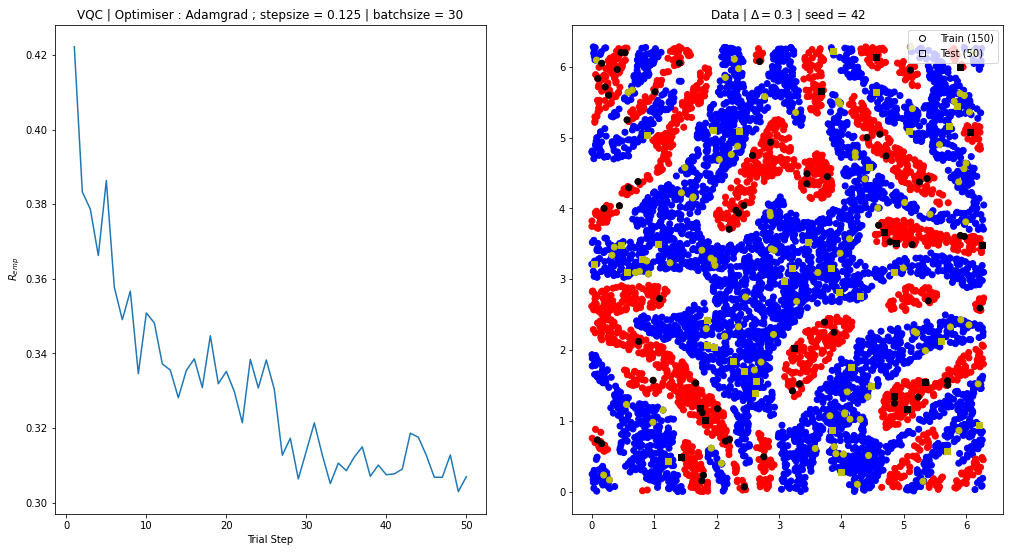

In [4]:
seed = numpy.random.randint(low=0,high= 100)
print("seed = "+ str(seed))

%run gen_binary_rz.py

DATA_PATH = "data/"

file = open(DATA_PATH + "params.json")

params = json.load(file)
delta = params["delta"]
n_points = params["n_points"]

file.close()

# Load data
Xs = np.zeros(shape=(n_points, 2))
Ys = np.zeros(shape=(n_points,))

with open(DATA_PATH + "binary_data.csv", mode="r") as file:
    csvFile = csv.reader(file)
    for i, row in enumerate(csvFile):
        Xs[i] = np.array([float(row[0]), float(row[1])])
        Ys[i] = float(row[2])
        if i == n_points:
            break

n_samples = 200  # number of train/test samples
X_data, Y_data = Xs[:n_samples], Ys[:n_samples]
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data)

def powerset(iterable, mx):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    pset = chain.from_iterable(combinations(s, r) for r in range(len(s) + 1))
    return [l for l in list(pset) if len(l) == mx]

n_wires = 2  # number of qubits
S_size = 2  # number of interactions considered
depth = 2  # number of layers in ansatz
pset = powerset(range(n_wires), S_size)

def encode_data(x):
    """Non-linear encoding (transformation) of one input data vector

    Args:
        x : shape (2,) tensor containing one input data vector

    Returns:
        triple of data encoded coefficients phi_1, phi_2, phi_{1,2}
    """

    return x[0], x[1], (np.pi - x[0]) * (np.pi - x[1])

def feature_map(x):
    """Short depth feature map with entanglement

    Args:
        x : shape (3,) tensor containing one encoded data vector
    """
    for _ in range(2):
        qml.Hadamard(wires=0)
        qml.Hadamard(wires=1)
        qml.RZ(x[0], wires=0)
        qml.RZ(x[1], wires=1)
        qml.CNOT(wires=[0, 1])
        qml.RZ(x[2], wires=1)
        qml.CNOT(wires=[0, 1])

def ansatz(params):
    """VQC ansatz using single-qubits unitaries and entangling gates

    Args:
        params : shape (`depth` + 1, `n_wires`, 3) tensor containing trainable parameters
    """
    for j in range(n_wires):
         qml.Rot(params[0, j, 0], params[0, j, 1], params[0, j, 2], wires=j)
    
    for i in range(1,depth+1):
         for s in pset:
            qml.CZ(wires=s)
            for j in range(n_wires):
                qml.Rot(params[i, j, 0], params[i, j, 1], params[i, j, 2], wires=j)

def circuit(params, x):
    """Havlicek et al. variational quantum circuit

    Args:
        params : shape (`depth` + 1, `n_wires`, 3) tensor containing trainable parameters
        x : shape (2,) tensor containing one input data vector

    Returns:
        shape(2 * 'n_wires',) tensor containing Z basis measurement probability on each qubit
    """

    feature_map(encode_data(x))  # prepare initial feature map state
    ansatz(params)  # apply discriminator circuit

    return qml.probs(wires=range(n_wires))


dev_local = qml.device("default.qubit", wires=n_wires, shots=shots)

qnode_local = qml.QNode(circuit, dev_local)

np.random.seed(seed)
params = (
    2 * np.pi * np.random.randn(depth + 1, n_wires, 3, requires_grad=True)
)  # random initial circuit parameters

def err_prob(params, x, y, R, bias=0):
    """Error probability of assigning a wrong label

    Args:
        x : shape (2,) tensor containing one input data vector
        y : shape (1,) tensor containing associated label
        params : shape (`depth` + 1, `n_wires`, 3) tensor containing trainable parameters
        R : int number of circuit evaluations (shots)
        bias : optional bias parameter in [-1,+1]

    Returns:
        probability that the VQC computed label m(x) = y' is assigned incorrectly
    """

    bprobs = qnode_local(params, x)  # probabilities for each basis state
    cprobs = (
        bprobs[0] + bprobs[3],
        bprobs[1] + bprobs[2],
    )  # probabilities for each eigenstate of parity Z_1 Z_2
    prob_correct = cprobs[int(0.5 - 0.5 * y)]  # probability of choosing correct label

    # Intermediate evaluation of equation from supplement using derived p_y(x) i.e. prob_correct
    val = (np.sqrt(R) * (0.5 - prob_correct - 0.5 * y * bias)) / (
        np.sqrt(2 * (1 - prob_correct) * prob_correct)
    )

    return 1 / (
        1 + np.exp(-val)
    )  # binomial CDF for R >> 1 approximated using sigmoid function

def cost(params, Xs, Ys, R):
    """Cost function for circuit optimization

    Args:
        params : shape (`depth` + 1, `n_wires`, 3) tensor containing trainable parameters
        Xs : shape (n,2) tensor containing input data vectors
        Ys : shape (n,) tensor containing associated labels
        R : int number of circuit evaluations (shots)

    Returns:
        the empirical risk i.e. the error probability averaged over all data points

    """

    ep_sum = 0  # initialize error probabilities sum
    for i in range(
        Xs.shape[0]
    ):  # compute sum of error probabilities over all data points
        ep_sum += err_prob(params, Xs[i], Ys[i], R)

    return ep_sum / Xs.shape[0]  # return average over all data points

# Gradient-based training
costs = []
times = []

opt = qml.AdagradOptimizer(stepsize)

for i in range(iterations):

    # Generate the batch
    batch_index = np.random.randint(0, X_train.shape[0], (batch_size,))
    X_batch = X_train[batch_index]
    Y_batch = Y_train[batch_index]

    t0 = time.time()

    # Update parameters by a single step.
    params = opt.step(lambda var: cost(var, X_batch, Y_batch, shots), params)

    t1 = time.time()

    # Compute cost
    cost_current = cost(params, X_train, Y_train, shots)
    

    costs.append(cost_current)
    times.append(t1 - t0)
    print(f"Cost at step {i}: {round(float(costs[-1]), 4)}") ##checkflag
    # print(f"Time at step {i}: {round(float(times[-1]), 4)}") ##checkflag

print(f"Initial cost: {round(float(costs[0]), 4)}")
print(f"Cost at step {iterations}: {round(float(costs[-1]), 4)}")
print(f"Avg time per step: {round(sum(times)/len(times), 4)} sec")

# Output folder
# time_str = time.strftime("%Y%m%d-%H%M%S")
VQC_OUT = f"vqc/{str(seed)}"
os.makedirs(VQC_OUT, exist_ok=True)

params_csv = f"{VQC_OUT}/{TEAM_NAME}_params.csv"
costs_csv = f"{VQC_OUT}/{TEAM_NAME}_costs.csv"

np.savetxt(params_csv, params.reshape(n_wires * (depth + 1), 3))
print(f"\nParameters saved to {params_csv}")

np.savetxt(
    costs_csv,
    np.vstack((range(iterations), costs[:iterations])).T,
    delimiter=", ",
)
print(f"Costs saved to {costs_csv}")

split_xs = lambda x: [[x[i][j] for i in range(len(x))] for j in [0, 1]]

xi, xj = split_xs(Xs)
xi_train, xj_train = split_xs(X_train)
xi_test, xj_test = split_xs(X_test)

label_circle = mlines.Line2D(
    [],
    [],
    color="none",
    marker="o",
    markerfacecolor="none",
    markeredgecolor="black",
    label=f"Train ({len(X_train)})",
)
label_square = mlines.Line2D(
    [],
    [],
    color="none",
    marker="s",
    markerfacecolor="none",
    markeredgecolor="black",
    label=f"Test ({len(X_test)})",
)

fig, ax = plt.subplots(1,2, figsize=(17,9))

ax[0].set_title("VQC | Optimiser : Adamgrad ; stepsize = " + str(stepsize) +" | batchsize = "+ str(batch_size))
ax[0].set_xlabel("Trial Step")
ax[0].set_ylabel("$R_{emp}$")
ax[0].plot(range(1, iterations + 1), costs)

ax[1].set_title(f"Data | $\Delta = {delta}$" + " | seed = " + str(seed))
ax[1].scatter(xi, xj, marker="o", c=["r" if v == 1.0 else "b" for v in Ys])
ax[1].scatter(xi_train, xj_train, c=["k" if v == 1.0 else "y" for v in Y_train])
ax[1].scatter(xi_test, xj_test, marker="s", c=["k" if v == 1.0 else "y" for v in Y_test])
ax[1].legend(handles=[label_circle, label_square], loc="upper right")


plt.savefig(DATA_PATH + "exp_rz | seed = "+str(seed) )

plt.show()

seed = 32
Cost at step 0: 0.461
Cost at step 1: 0.423
Cost at step 2: 0.3963
Cost at step 3: 0.3812
Cost at step 4: 0.4042
Cost at step 5: 0.4149
Cost at step 6: 0.4141
Cost at step 7: 0.4164
Cost at step 8: 0.4091
Cost at step 9: 0.392
Cost at step 10: 0.3976
Cost at step 11: 0.396
Cost at step 12: 0.3879
Cost at step 13: 0.4011
Cost at step 14: 0.3857
Cost at step 15: 0.3747
Cost at step 16: 0.374
Cost at step 17: 0.3719
Cost at step 18: 0.3859
Cost at step 19: 0.3727
Cost at step 20: 0.365
Cost at step 21: 0.37
Cost at step 22: 0.3725
Cost at step 23: 0.3808
Cost at step 24: 0.3649
Cost at step 25: 0.3751
Cost at step 26: 0.3744
Cost at step 27: 0.374
Cost at step 28: 0.3697
Cost at step 29: 0.3626
Cost at step 30: 0.373
Cost at step 31: 0.3783
Cost at step 32: 0.3792
Cost at step 33: 0.3679
Cost at step 34: 0.3658
Cost at step 35: 0.3681
Cost at step 36: 0.3692
Cost at step 37: 0.3658
Cost at step 38: 0.37
Cost at step 39: 0.3686
Cost at step 40: 0.3654
Cost at step 41: 0.3634
Cost

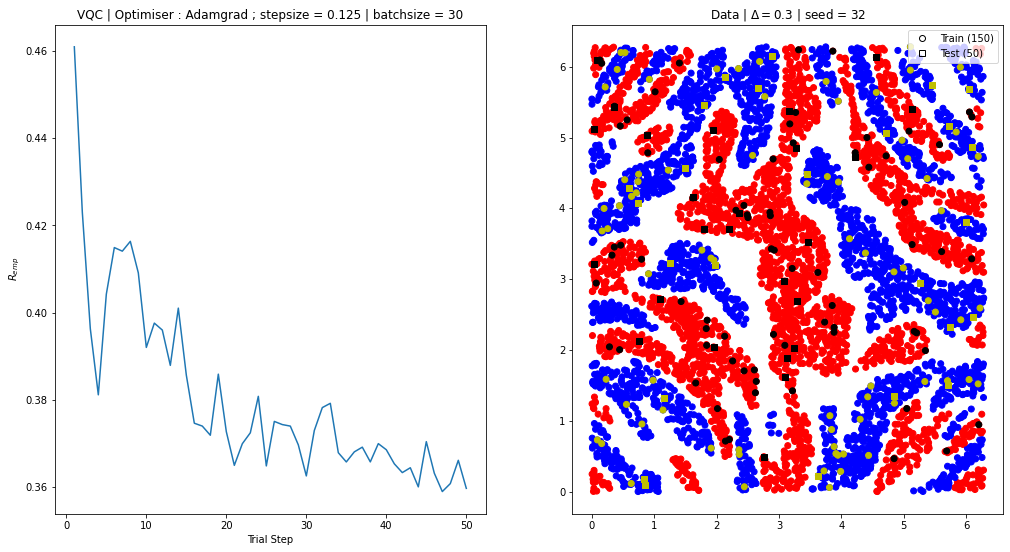

In [5]:
seed = numpy.random.randint(low=0,high= 100)
print("seed = "+ str(seed))

%run gen_binary_rz.py

DATA_PATH = "data/"

file = open(DATA_PATH + "params.json")

params = json.load(file)
delta = params["delta"]
n_points = params["n_points"]

file.close()

# Load data
Xs = np.zeros(shape=(n_points, 2))
Ys = np.zeros(shape=(n_points,))

with open(DATA_PATH + "binary_data.csv", mode="r") as file:
    csvFile = csv.reader(file)
    for i, row in enumerate(csvFile):
        Xs[i] = np.array([float(row[0]), float(row[1])])
        Ys[i] = float(row[2])
        if i == n_points:
            break

n_samples = 200  # number of train/test samples
X_data, Y_data = Xs[:n_samples], Ys[:n_samples]
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data)

def powerset(iterable, mx):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    pset = chain.from_iterable(combinations(s, r) for r in range(len(s) + 1))
    return [l for l in list(pset) if len(l) == mx]

n_wires = 2  # number of qubits
S_size = 2  # number of interactions considered
depth = 2  # number of layers in ansatz
pset = powerset(range(n_wires), S_size)

def encode_data(x):
    """Non-linear encoding (transformation) of one input data vector

    Args:
        x : shape (2,) tensor containing one input data vector

    Returns:
        triple of data encoded coefficients phi_1, phi_2, phi_{1,2}
    """

    return x[0], x[1], (np.pi - x[0]) * (np.pi - x[1])

def feature_map(x):
    """Short depth feature map with entanglement

    Args:
        x : shape (3,) tensor containing one encoded data vector
    """
    for _ in range(2):
        qml.Hadamard(wires=0)
        qml.Hadamard(wires=1)
        qml.RZ(x[0], wires=0)
        qml.RZ(x[1], wires=1)
        qml.CNOT(wires=[0, 1])
        qml.RZ(x[2], wires=1)
        qml.CNOT(wires=[0, 1])

def ansatz(params):
    """VQC ansatz using single-qubits unitaries and entangling gates

    Args:
        params : shape (`depth` + 1, `n_wires`, 3) tensor containing trainable parameters
    """
    for j in range(n_wires):
         qml.Rot(params[0, j, 0], params[0, j, 1], params[0, j, 2], wires=j)
    
    for i in range(1,depth+1):
         for s in pset:
            qml.CZ(wires=s)
            for j in range(n_wires):
                qml.Rot(params[i, j, 0], params[i, j, 1], params[i, j, 2], wires=j)

def circuit(params, x):
    """Havlicek et al. variational quantum circuit

    Args:
        params : shape (`depth` + 1, `n_wires`, 3) tensor containing trainable parameters
        x : shape (2,) tensor containing one input data vector

    Returns:
        shape(2 * 'n_wires',) tensor containing Z basis measurement probability on each qubit
    """

    feature_map(encode_data(x))  # prepare initial feature map state
    ansatz(params)  # apply discriminator circuit

    return qml.probs(wires=range(n_wires))


dev_local = qml.device("default.qubit", wires=n_wires, shots=shots)

qnode_local = qml.QNode(circuit, dev_local)

np.random.seed(seed)
params = (
    2 * np.pi * np.random.randn(depth + 1, n_wires, 3, requires_grad=True)
)  # random initial circuit parameters

def err_prob(params, x, y, R, bias=0):
    """Error probability of assigning a wrong label

    Args:
        x : shape (2,) tensor containing one input data vector
        y : shape (1,) tensor containing associated label
        params : shape (`depth` + 1, `n_wires`, 3) tensor containing trainable parameters
        R : int number of circuit evaluations (shots)
        bias : optional bias parameter in [-1,+1]

    Returns:
        probability that the VQC computed label m(x) = y' is assigned incorrectly
    """

    bprobs = qnode_local(params, x)  # probabilities for each basis state
    cprobs = (
        bprobs[0] + bprobs[3],
        bprobs[1] + bprobs[2],
    )  # probabilities for each eigenstate of parity Z_1 Z_2
    prob_correct = cprobs[int(0.5 - 0.5 * y)]  # probability of choosing correct label

    # Intermediate evaluation of equation from supplement using derived p_y(x) i.e. prob_correct
    val = (np.sqrt(R) * (0.5 - prob_correct - 0.5 * y * bias)) / (
        np.sqrt(2 * (1 - prob_correct) * prob_correct)
    )

    return 1 / (
        1 + np.exp(-val)
    )  # binomial CDF for R >> 1 approximated using sigmoid function

def cost(params, Xs, Ys, R):
    """Cost function for circuit optimization

    Args:
        params : shape (`depth` + 1, `n_wires`, 3) tensor containing trainable parameters
        Xs : shape (n,2) tensor containing input data vectors
        Ys : shape (n,) tensor containing associated labels
        R : int number of circuit evaluations (shots)

    Returns:
        the empirical risk i.e. the error probability averaged over all data points

    """

    ep_sum = 0  # initialize error probabilities sum
    for i in range(
        Xs.shape[0]
    ):  # compute sum of error probabilities over all data points
        ep_sum += err_prob(params, Xs[i], Ys[i], R)

    return ep_sum / Xs.shape[0]  # return average over all data points

# Gradient-based training
costs = []
times = []

opt = qml.AdagradOptimizer(stepsize)

for i in range(iterations):

    # Generate the batch
    batch_index = np.random.randint(0, X_train.shape[0], (batch_size,))
    X_batch = X_train[batch_index]
    Y_batch = Y_train[batch_index]

    t0 = time.time()

    # Update parameters by a single step.
    params = opt.step(lambda var: cost(var, X_batch, Y_batch, shots), params)

    t1 = time.time()

    # Compute cost
    cost_current = cost(params, X_train, Y_train, shots)
    

    costs.append(cost_current)
    times.append(t1 - t0)
    print(f"Cost at step {i}: {round(float(costs[-1]), 4)}") ##checkflag
    # print(f"Time at step {i}: {round(float(times[-1]), 4)}") ##checkflag

print(f"Initial cost: {round(float(costs[0]), 4)}")
print(f"Cost at step {iterations}: {round(float(costs[-1]), 4)}")
print(f"Avg time per step: {round(sum(times)/len(times), 4)} sec")

# Output folder
# time_str = time.strftime("%Y%m%d-%H%M%S")
VQC_OUT = f"vqc/{str(seed)}"
os.makedirs(VQC_OUT, exist_ok=True)

params_csv = f"{VQC_OUT}/{TEAM_NAME}_params.csv"
costs_csv = f"{VQC_OUT}/{TEAM_NAME}_costs.csv"

np.savetxt(params_csv, params.reshape(n_wires * (depth + 1), 3))
print(f"\nParameters saved to {params_csv}")

np.savetxt(
    costs_csv,
    np.vstack((range(iterations), costs[:iterations])).T,
    delimiter=", ",
)
print(f"Costs saved to {costs_csv}")

split_xs = lambda x: [[x[i][j] for i in range(len(x))] for j in [0, 1]]

xi, xj = split_xs(Xs)
xi_train, xj_train = split_xs(X_train)
xi_test, xj_test = split_xs(X_test)

label_circle = mlines.Line2D(
    [],
    [],
    color="none",
    marker="o",
    markerfacecolor="none",
    markeredgecolor="black",
    label=f"Train ({len(X_train)})",
)
label_square = mlines.Line2D(
    [],
    [],
    color="none",
    marker="s",
    markerfacecolor="none",
    markeredgecolor="black",
    label=f"Test ({len(X_test)})",
)

fig, ax = plt.subplots(1,2, figsize=(17,9))

ax[0].set_title("VQC | Optimiser : Adamgrad ; stepsize = " + str(stepsize) +" | batchsize = "+ str(batch_size))
ax[0].set_xlabel("Trial Step")
ax[0].set_ylabel("$R_{emp}$")
ax[0].plot(range(1, iterations + 1), costs)

ax[1].set_title(f"Data | $\Delta = {delta}$" + " | seed = " + str(seed))
ax[1].scatter(xi, xj, marker="o", c=["r" if v == 1.0 else "b" for v in Ys])
ax[1].scatter(xi_train, xj_train, c=["k" if v == 1.0 else "y" for v in Y_train])
ax[1].scatter(xi_test, xj_test, marker="s", c=["k" if v == 1.0 else "y" for v in Y_test])
ax[1].legend(handles=[label_circle, label_square], loc="upper right")


plt.savefig(DATA_PATH + "exp_rz | seed = "+str(seed) )

plt.show()

seed = 5
Cost at step 0: 0.4023
Cost at step 1: 0.4053
Cost at step 2: 0.4009
Cost at step 3: 0.4194
Cost at step 4: 0.404
Cost at step 5: 0.3931
Cost at step 6: 0.3751
Cost at step 7: 0.38
Cost at step 8: 0.3885
Cost at step 9: 0.3756
Cost at step 10: 0.3674
Cost at step 11: 0.3801
Cost at step 12: 0.3825
Cost at step 13: 0.3844
Cost at step 14: 0.3749
Cost at step 15: 0.3726
Cost at step 16: 0.3714
Cost at step 17: 0.3733
Cost at step 18: 0.3746
Cost at step 19: 0.3755
Cost at step 20: 0.3677
Cost at step 21: 0.3693
Cost at step 22: 0.3779
Cost at step 23: 0.3758
Cost at step 24: 0.3784
Cost at step 25: 0.3769
Cost at step 26: 0.3738
Cost at step 27: 0.3764
Cost at step 28: 0.37
Cost at step 29: 0.3643
Cost at step 30: 0.3633
Cost at step 31: 0.3738
Cost at step 32: 0.3726
Cost at step 33: 0.3785
Cost at step 34: 0.3767
Cost at step 35: 0.3784
Cost at step 36: 0.3799
Cost at step 37: 0.3756
Cost at step 38: 0.3616
Cost at step 39: 0.3729
Cost at step 40: 0.3794
Cost at step 41: 0.371

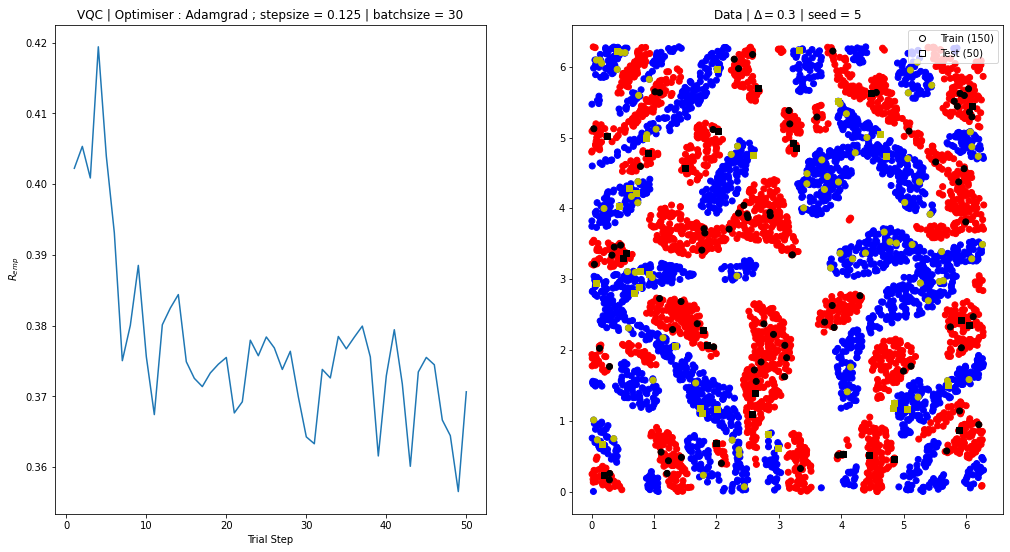

In [6]:
seed = numpy.random.randint(low=0,high= 100)
print("seed = "+ str(seed))

%run gen_binary_rz.py

DATA_PATH = "data/"

file = open(DATA_PATH + "params.json")

params = json.load(file)
delta = params["delta"]
n_points = params["n_points"]

file.close()

# Load data
Xs = np.zeros(shape=(n_points, 2))
Ys = np.zeros(shape=(n_points,))

with open(DATA_PATH + "binary_data.csv", mode="r") as file:
    csvFile = csv.reader(file)
    for i, row in enumerate(csvFile):
        Xs[i] = np.array([float(row[0]), float(row[1])])
        Ys[i] = float(row[2])
        if i == n_points:
            break

n_samples = 200  # number of train/test samples
X_data, Y_data = Xs[:n_samples], Ys[:n_samples]
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data)

def powerset(iterable, mx):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    pset = chain.from_iterable(combinations(s, r) for r in range(len(s) + 1))
    return [l for l in list(pset) if len(l) == mx]

n_wires = 2  # number of qubits
S_size = 2  # number of interactions considered
depth = 2  # number of layers in ansatz
pset = powerset(range(n_wires), S_size)

def encode_data(x):
    """Non-linear encoding (transformation) of one input data vector

    Args:
        x : shape (2,) tensor containing one input data vector

    Returns:
        triple of data encoded coefficients phi_1, phi_2, phi_{1,2}
    """

    return x[0], x[1], (np.pi - x[0]) * (np.pi - x[1])

def feature_map(x):
    """Short depth feature map with entanglement

    Args:
        x : shape (3,) tensor containing one encoded data vector
    """
    for _ in range(2):
        qml.Hadamard(wires=0)
        qml.Hadamard(wires=1)
        qml.RZ(x[0], wires=0)
        qml.RZ(x[1], wires=1)
        qml.CNOT(wires=[0, 1])
        qml.RZ(x[2], wires=1)
        qml.CNOT(wires=[0, 1])

def ansatz(params):
    """VQC ansatz using single-qubits unitaries and entangling gates

    Args:
        params : shape (`depth` + 1, `n_wires`, 3) tensor containing trainable parameters
    """
    for j in range(n_wires):
         qml.Rot(params[0, j, 0], params[0, j, 1], params[0, j, 2], wires=j)
    
    for i in range(1,depth+1):
         for s in pset:
            qml.CZ(wires=s)
            for j in range(n_wires):
                qml.Rot(params[i, j, 0], params[i, j, 1], params[i, j, 2], wires=j)

def circuit(params, x):
    """Havlicek et al. variational quantum circuit

    Args:
        params : shape (`depth` + 1, `n_wires`, 3) tensor containing trainable parameters
        x : shape (2,) tensor containing one input data vector

    Returns:
        shape(2 * 'n_wires',) tensor containing Z basis measurement probability on each qubit
    """

    feature_map(encode_data(x))  # prepare initial feature map state
    ansatz(params)  # apply discriminator circuit

    return qml.probs(wires=range(n_wires))


dev_local = qml.device("default.qubit", wires=n_wires, shots=shots)

qnode_local = qml.QNode(circuit, dev_local)

np.random.seed(seed)
params = (
    2 * np.pi * np.random.randn(depth + 1, n_wires, 3, requires_grad=True)
)  # random initial circuit parameters

def err_prob(params, x, y, R, bias=0):
    """Error probability of assigning a wrong label

    Args:
        x : shape (2,) tensor containing one input data vector
        y : shape (1,) tensor containing associated label
        params : shape (`depth` + 1, `n_wires`, 3) tensor containing trainable parameters
        R : int number of circuit evaluations (shots)
        bias : optional bias parameter in [-1,+1]

    Returns:
        probability that the VQC computed label m(x) = y' is assigned incorrectly
    """

    bprobs = qnode_local(params, x)  # probabilities for each basis state
    cprobs = (
        bprobs[0] + bprobs[3],
        bprobs[1] + bprobs[2],
    )  # probabilities for each eigenstate of parity Z_1 Z_2
    prob_correct = cprobs[int(0.5 - 0.5 * y)]  # probability of choosing correct label

    # Intermediate evaluation of equation from supplement using derived p_y(x) i.e. prob_correct
    val = (np.sqrt(R) * (0.5 - prob_correct - 0.5 * y * bias)) / (
        np.sqrt(2 * (1 - prob_correct) * prob_correct)
    )

    return 1 / (
        1 + np.exp(-val)
    )  # binomial CDF for R >> 1 approximated using sigmoid function

def cost(params, Xs, Ys, R):
    """Cost function for circuit optimization

    Args:
        params : shape (`depth` + 1, `n_wires`, 3) tensor containing trainable parameters
        Xs : shape (n,2) tensor containing input data vectors
        Ys : shape (n,) tensor containing associated labels
        R : int number of circuit evaluations (shots)

    Returns:
        the empirical risk i.e. the error probability averaged over all data points

    """

    ep_sum = 0  # initialize error probabilities sum
    for i in range(
        Xs.shape[0]
    ):  # compute sum of error probabilities over all data points
        ep_sum += err_prob(params, Xs[i], Ys[i], R)

    return ep_sum / Xs.shape[0]  # return average over all data points

# Gradient-based training
costs = []
times = []

opt = qml.AdagradOptimizer(stepsize)

for i in range(iterations):

    # Generate the batch
    batch_index = np.random.randint(0, X_train.shape[0], (batch_size,))
    X_batch = X_train[batch_index]
    Y_batch = Y_train[batch_index]

    t0 = time.time()

    # Update parameters by a single step.
    params = opt.step(lambda var: cost(var, X_batch, Y_batch, shots), params)

    t1 = time.time()

    # Compute cost
    cost_current = cost(params, X_train, Y_train, shots)
    

    costs.append(cost_current)
    times.append(t1 - t0)
    print(f"Cost at step {i}: {round(float(costs[-1]), 4)}") ##checkflag
    # print(f"Time at step {i}: {round(float(times[-1]), 4)}") ##checkflag

print(f"Initial cost: {round(float(costs[0]), 4)}")
print(f"Cost at step {iterations}: {round(float(costs[-1]), 4)}")
print(f"Avg time per step: {round(sum(times)/len(times), 4)} sec")

# Output folder
# time_str = time.strftime("%Y%m%d-%H%M%S")
VQC_OUT = f"vqc/{str(seed)}"
os.makedirs(VQC_OUT, exist_ok=True)

params_csv = f"{VQC_OUT}/{TEAM_NAME}_params.csv"
costs_csv = f"{VQC_OUT}/{TEAM_NAME}_costs.csv"

np.savetxt(params_csv, params.reshape(n_wires * (depth + 1), 3))
print(f"\nParameters saved to {params_csv}")

np.savetxt(
    costs_csv,
    np.vstack((range(iterations), costs[:iterations])).T,
    delimiter=", ",
)
print(f"Costs saved to {costs_csv}")

split_xs = lambda x: [[x[i][j] for i in range(len(x))] for j in [0, 1]]

xi, xj = split_xs(Xs)
xi_train, xj_train = split_xs(X_train)
xi_test, xj_test = split_xs(X_test)

label_circle = mlines.Line2D(
    [],
    [],
    color="none",
    marker="o",
    markerfacecolor="none",
    markeredgecolor="black",
    label=f"Train ({len(X_train)})",
)
label_square = mlines.Line2D(
    [],
    [],
    color="none",
    marker="s",
    markerfacecolor="none",
    markeredgecolor="black",
    label=f"Test ({len(X_test)})",
)

fig, ax = plt.subplots(1,2, figsize=(17,9))

ax[0].set_title("VQC | Optimiser : Adamgrad ; stepsize = " + str(stepsize) +" | batchsize = "+ str(batch_size))
ax[0].set_xlabel("Trial Step")
ax[0].set_ylabel("$R_{emp}$")
ax[0].plot(range(1, iterations + 1), costs)

ax[1].set_title(f"Data | $\Delta = {delta}$" + " | seed = " + str(seed))
ax[1].scatter(xi, xj, marker="o", c=["r" if v == 1.0 else "b" for v in Ys])
ax[1].scatter(xi_train, xj_train, c=["k" if v == 1.0 else "y" for v in Y_train])
ax[1].scatter(xi_test, xj_test, marker="s", c=["k" if v == 1.0 else "y" for v in Y_test])
ax[1].legend(handles=[label_circle, label_square], loc="upper right")


plt.savefig(DATA_PATH + "exp_rz | seed = "+str(seed) )

plt.show()